In [1]:
import numpy as np
from numpy import random
import scipy as sp

import anndata as ad
from scanpy.api.tl import diffmap
from scanpy.api.tl import umap
from scanpy.api import pp
import matplotlib.pyplot as plt

# make sure to use viridis as the default color map
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'viridis'

In [2]:
import tree
import simulation as sim
import sim_utils as sut
import count_model as cm

In [68]:
rseed = 1992
np.random.seed(rseed)

In [69]:
top = [["A", "B"], ["B", "C"], ["C", "D"], ["D", "E"]]
top = [["A", "B"]]

In [70]:
G = 500
t = tree.Tree(topology=top, G=G, time={"A":30, "B":30, "C":30, "D":30, "E":30}, num_branches=5, branch_points=0)
t = tree.Tree(topology=top, G=G, time={"A":50, "B":50}, num_branches=2, branch_points=0, modules=10)

In [71]:
uMs, Ws, Hs = sim.simulate_lineage(t, a=0.05)

/home/soedinglaptop/miniconda3/envs/py37/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [72]:
gene_scale = sut.simulate_base_gene_exp(t, uMs)
t.add_genes(uMs, gene_scale)

In [73]:
alpha1 = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=t.G))
beta1 = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=t.G)) + 1

In [74]:
X1, labs1, brns1, scalings1 = sim.sample_whole_tree(t, 5, alpha=alpha1, beta=beta1)

# normalize gene expression by library size
X1 = (X1.transpose() / scalings1).transpose()

In [75]:
data1 = ad.AnnData(X1)
pp.neighbors(data1, use_rep='X')
umap(data1)
dm1 = data1.obsm["X_umap"]
br_names1, indices1 = np.unique(brns1, return_inverse=True)

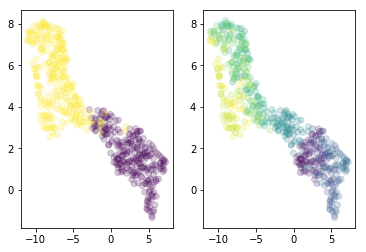

In [76]:
fig, ax = plt.subplots(ncols=2)
# fig.set_size_inches(w=12, h=12)
ax[0].scatter(dm1[:, 0], dm1[:, 1], c=indices1, alpha=0.2)
ax[1].scatter(dm1[:, 0], dm1[:, 1], c=labs1, alpha=0.2)

In [64]:
spaced_sample_times = np.arange(0, t.get_max_time(), 5)
spaced_times = np.repeat(spaced_sample_times, 100)

In [65]:
X2, labs2, brns2, scalings2 = sim._sample_data_at_times(t, spaced_times, alpha=alpha1, beta=beta1)

# normalize gene expression by library size
X2 = (X2.transpose() / scalings2).transpose()

In [66]:
data2 = ad.AnnData(X2)
pp.neighbors(data2, use_rep='X')
umap(data2)
dm2 = data2.obsm["X_umap"]
br_names2, indices2 = np.unique(brns2, return_inverse=True)

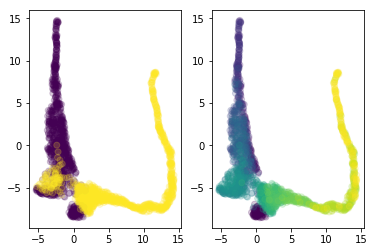

In [67]:
fig, ax = plt.subplots(ncols=2)
# fig.set_size_inches(w=12, h=12)
ax[0].scatter(dm2[:, 0], dm2[:, 1], c=indices2, alpha=0.2)
ax[1].scatter(dm2[:, 0], dm2[:, 1], c=labs2, alpha=0.2)